In [45]:
pwd()

"/data3/yasu/capsid/docking_pairwise/4ake_zdock_iter"

In [46]:
using Printf, DelimitedFiles
using Plots
using DataFrames
using Revise, MDToolbox
using Statistics

In [47]:
#using BSON: @save, @load
#@load "df.bson" df

In [48]:
using JLD2

df = load("df.jld2")["df"]

Row,fnames,score,omega,phi,prou,d,struc
,Any,Any,Any,Any,Any,Any,Any
1,1/complex.1.pdb,1024.65,"[-0.0281216, 0.968563, 0.247175]",142.637,"[-8.75967, 5.99937, -24.5054]",-14.8287,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … 4.49 -35.62 -44.75 |"
2,1/complex.2.pdb,995.933,"[0.574083, -0.500062, -0.648356]",147.139,"[-14.8289, 9.28651, -20.2926]",-1.50474,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … -12.15 22.01 -54.26 |"
3,1/complex.3.pdb,975.648,"[0.586679, -0.575964, -0.569274]",159.814,"[-12.8229, 8.26763, -21.5797]",-1.5971,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … -0.67 20.45 -52.36 |"
4,1/complex.4.pdb,962.002,"[-0.135677, -0.937363, 0.320845]",150.089,"[-11.0709, -7.65869, -27.0568]",18.9014,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … -19.62 -45.58 -14.85 |"
5,1/complex.5.pdb,915.738,"[-0.588624, 0.61065, 0.529744]",163.212,"[-12.2797, 7.92458, -22.7795]",-0.454163,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … 16.18 19.32 -41.88 |"
6,1/complex.6.pdb,909.798,"[0.0512852, 0.569022, -0.820722]",93.3045,"[-11.8917, -23.1444, -16.7896]",-22.5546,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … -17.46 -36.74 2.86 |"
7,1/complex.7.pdb,874.365,"[0.235571, -0.971857, -0.000318399]",151.007,"[-15.8386, -3.83192, -22.0794]",15.4782,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … -7.09 -42.42 -26.51 |"
8,1/complex.8.pdb,872.42,"[-0.855621, 0.514046, -0.0605748]",174.23,"[-5.56816, -11.4507, -18.5221]",26.1247,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … -16.62 15.01 -18.60 |"
9,1/complex.9.pdb,868.374,"[-0.778727, 0.603605, 0.17101]",43.4144,"[20.4586, 30.4552, -14.334]",-4.34687,"1x3312 TrjArray{Float64, Int64}\n| -10.93 -24.89 -9.52 | … 8.04 -21.82 26.25 |"


In [49]:
sort!(df, [:score], rev=true);
#dfs = vcat(df, df)
#sort!(dfs, [:score], rev=true)

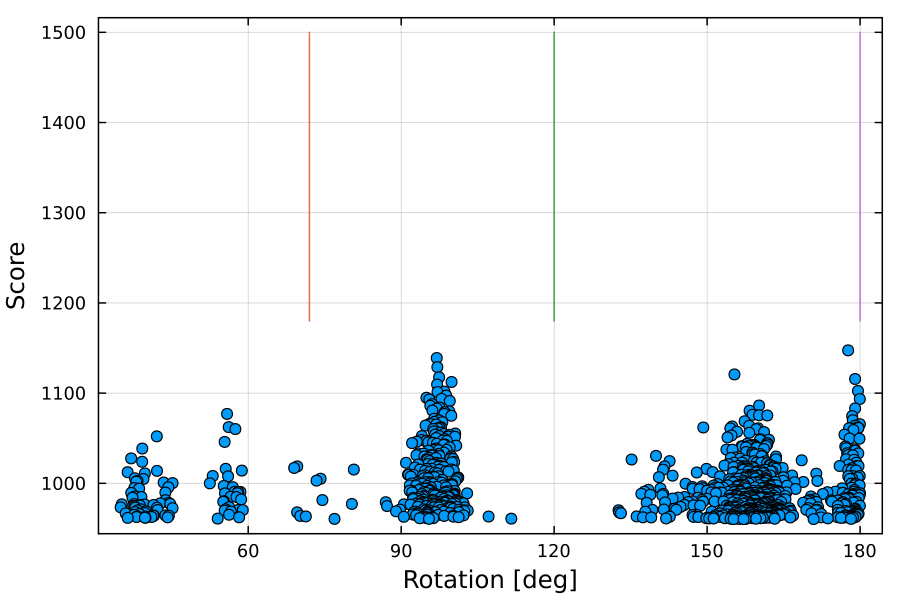

In [50]:
#pyplot()
plot(df.phi[1:1000], df.score[1:1000], seriestype=:scatter, dpi=250, label=nothing, box_style=:box)
xaxis!("Rotation [deg]"); yaxis!("Score")
#s = collect(970:1350)
s = collect(1180:1500)
plot!(fill(360/5, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/3, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/2, length(s)), s, label=nothing, dpi=150)

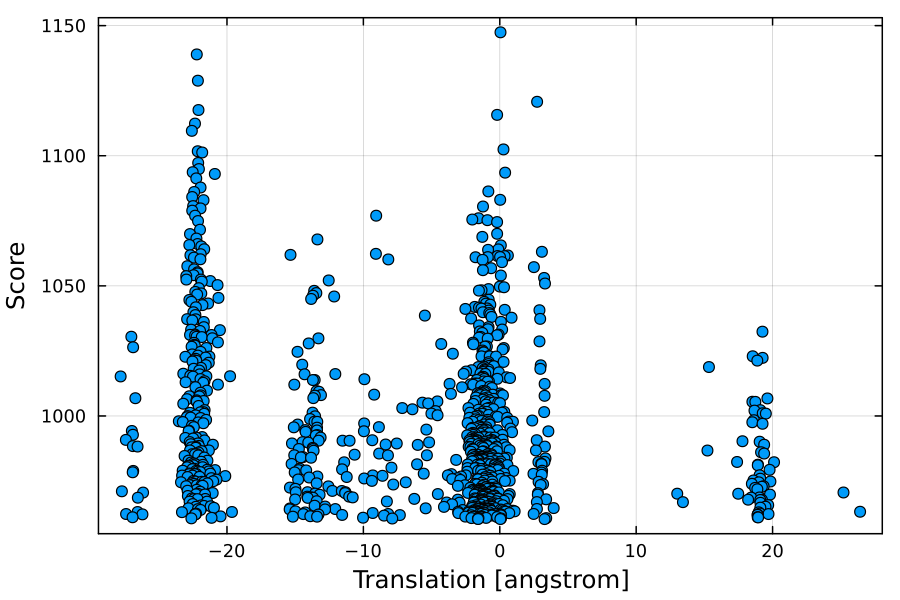

In [51]:
#pyplot()
plot(df.d[1:1000], df.score[1:1000], seriestype=:scatter, dpi=150, label=nothing, box_style=:box)
xaxis!("Translation [angstrom]"); yaxis!("Score")

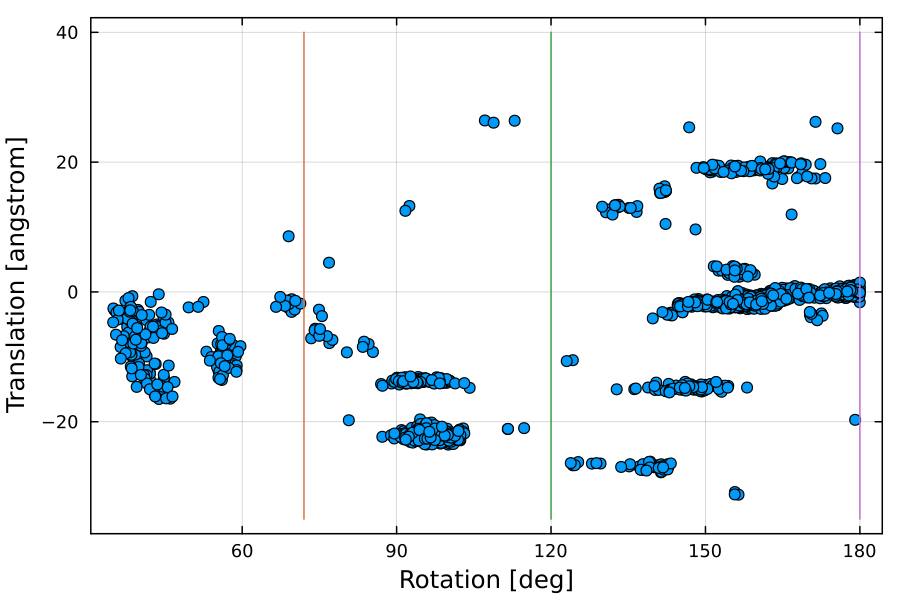

In [52]:
#pyplot()
plot(df.phi[1:2000], df.d[1:2000], seriestype=:scatter, dpi=150, label=nothing, box_style=:box)
xaxis!("Rotation [deg]"); yaxis!("Translation [angstrom]")
s = collect(-35:40)
plot!(fill(360/5, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/3, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/2, length(s)), s, label=nothing, dpi=150)

In [53]:
function create_heatmap(x, y, z, nx, ny)
    A = zeros(Float64, ny, nx)
    A .= -Inf64
    #edge_x = range(minimum(x), maximum(x), nx+1)
    edge_x = range(20, 185, nx+1)
    #edge_y = range(minimum(y), maximum(y), ny+1)
    edge_y = range(-40, 40, ny+1)
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .< edge_x[ix+1]
            id_y = edge_y[iy] .<= y .< edge_y[iy+1]
            id = id_x .& id_y
            if !isempty(z[id])
                A[iy, ix] = maximum(z[id])
            end
        end
    end
    grid_x = edge_x[1:end-1] .+ (0.5 * (edge_x[2] - edge_x[1]))
    grid_y = edge_y[1:end-1] .+ (0.5 * (edge_y[2] - edge_y[1]))
    return (z=A, x=grid_x, y=grid_y)
end

create_heatmap (generic function with 1 method)

In [54]:
function smooth_array(A, window_size)
    padded = pad_array(A, window_size)
    smoothed = similar(A)
    
    for i in 1:size(A, 1)
        for j in 1:size(A, 2)
            window = padded[i:i+window_size-1, j:j+window_size-1]
            valid_values = filter(x -> !isinf(x) && !isnan(x), window)
            smoothed[i, j] = isempty(valid_values) ? -Inf : mean(valid_values)
        end
    end
    
    return smoothed
end

function pad_array(A, window_size)
    pad_width = div(window_size - 1, 2)
    padded = fill(-Inf, size(A) .+ (2*pad_width, 2*pad_width))
    padded[pad_width+1:end-pad_width, pad_width+1:end-pad_width] = A
    return padded
end

function create_heatmap2(x, y, z, nx, ny; smooth_window=3)
    # Remove any NaN or Inf values from the input data
    valid_indices = .!isnan.(x) .& .!isinf.(x) .& .!isnan.(y) .& .!isinf.(y) .& .!isnan.(z) .& .!isinf.(z)
    x, y, z = x[valid_indices], y[valid_indices], z[valid_indices]

    # Check if there's any valid data left
    if isempty(x) || isempty(y) || isempty(z)
        error("No valid data points after removing NaN and Inf values.")
    end

    # Use the actual data range or the specified range, whichever is wider
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    edge_x = range(min(20, x_min), max(185, x_max), length=nx+1)
    edge_y = range(min(-40, y_min), max(40, y_max), length=ny+1)

    A = fill(-Inf, ny, nx)
    
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .<= edge_x[ix+1]
            id_y = edge_y[iy] .<= y .<= edge_y[iy+1]
            id = id_x .& id_y
            if any(id)
                A[iy, ix] = maximum(z[id])
            end
        end
    end
    
    # Apply smoothing
    A_smoothed = smooth_array(A, smooth_window)
    
    grid_x = edge_x[1:end-1] .+ (0.5 * step(edge_x))
    grid_y = edge_y[1:end-1] .+ (0.5 * step(edge_y))
    
    return (z=A_smoothed, x=grid_x, y=grid_y)
end

# 使用例
# result = create_heatmap(x, y, z, 100, 80, smooth_window=5)

# using Plots
# heatmap(result.x, result.y, result.z, 
#         c=:viridis, 
#         xlabel="X", 
#         ylabel="Y", 
#         title="Smoothed Heatmap",
#         yflip=true)

create_heatmap2 (generic function with 1 method)

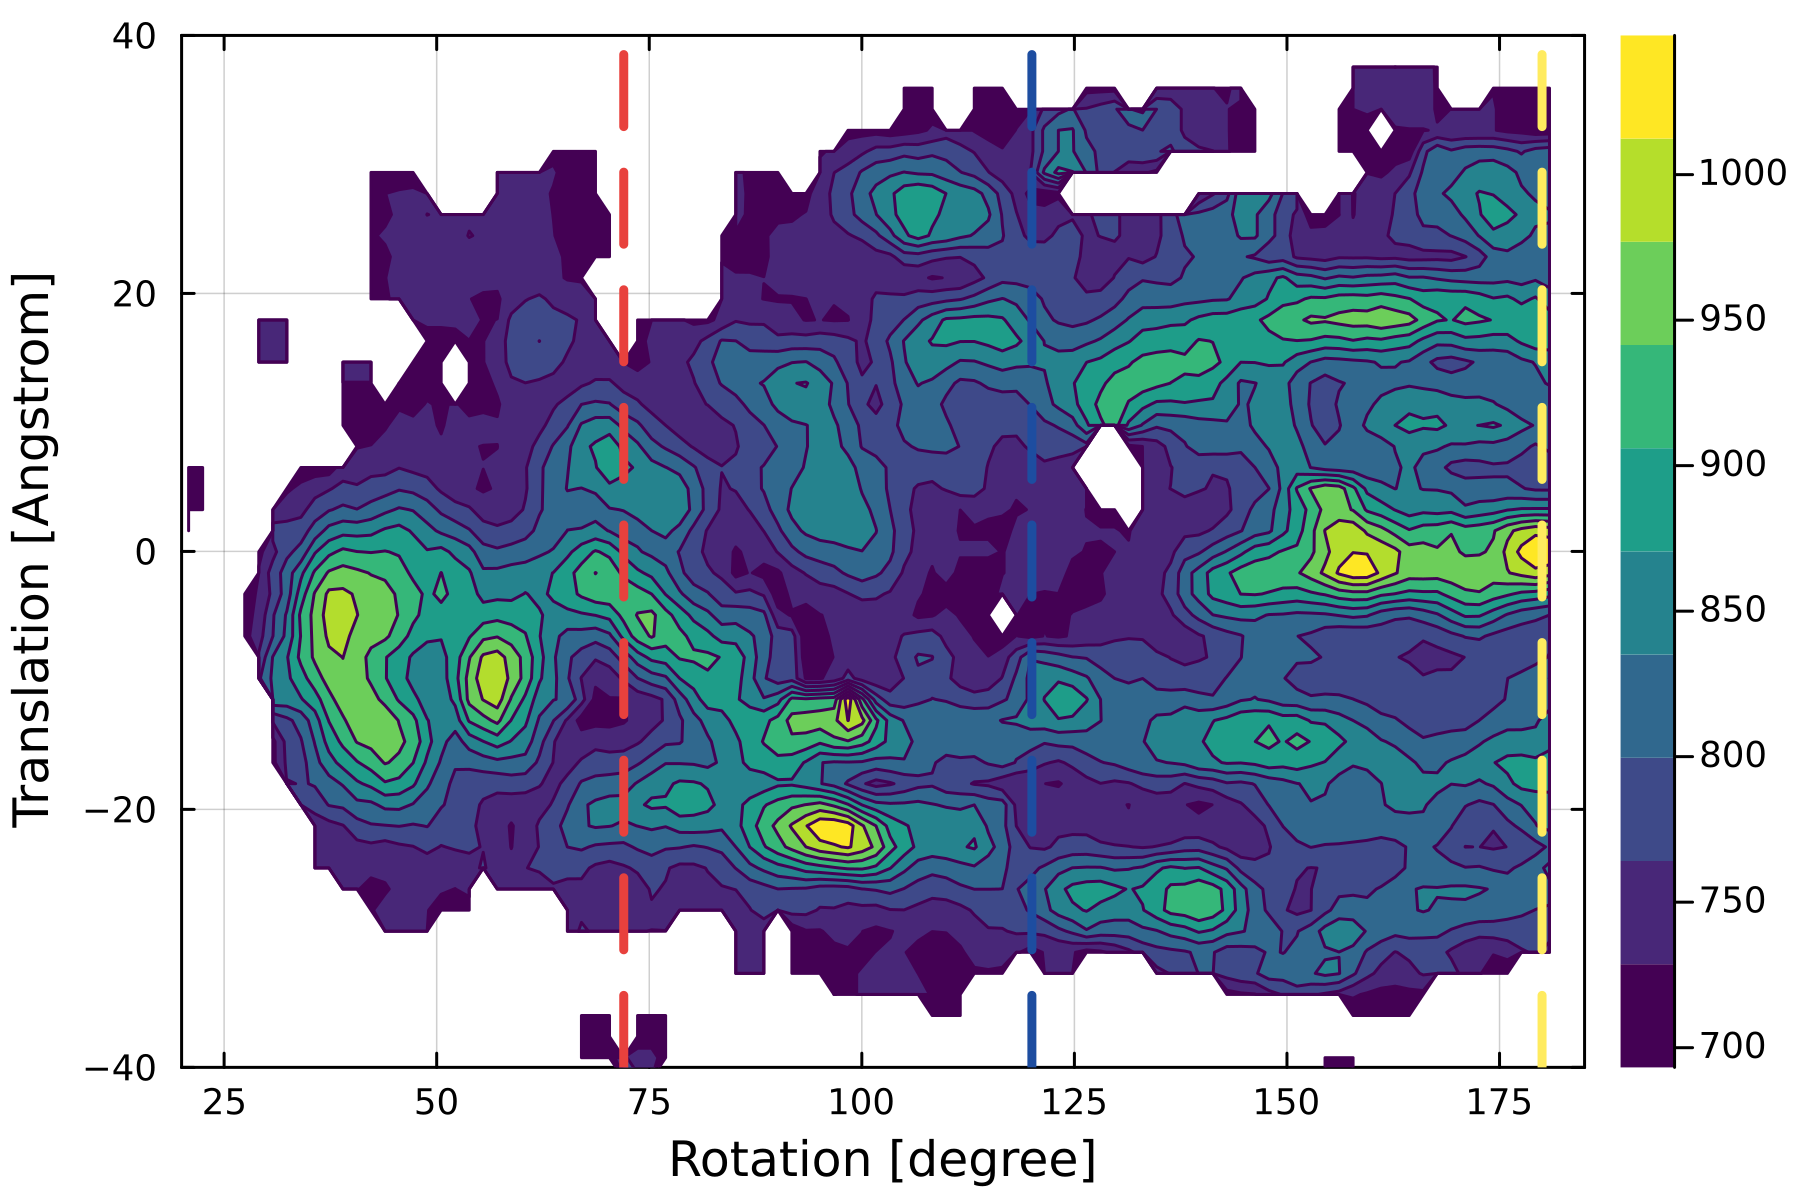

In [66]:
using Colors

n = 100000
F = create_heatmap2(df.phi[1:n], df.d[1:n], df.score[1:n], 100, 50)
p = plot(F.x, F.y, F.z, framestyle=:box, dpi=300, c=:viridis,  
     st=:contourf, levels=range(minimum(F.z[F.z .> -Inf]), maximum(F.z), 11))
     #clims=range(minimum(F.z[F.z .> -Inf]), maximum(F.z), 5))
     #color=range(minimum(F.z[F.z .> -Inf]), maximum(F.z), 100))
xlabel!("Rotation [degree]")
ylabel!("Translation [Angstrom]")

s = collect(-40:40)
plot!(fill(360/5, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#E8413D"), label=nothing)
plot!(fill(360/3, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#1D4DA0"), label=nothing)
plot!(fill(360/2, length(s)), s, linestyle=:dash, linewidth=3.0, linecolor=parse(Colorant, "#FFEB5F"), label=nothing)

xlims!((20, 185))
ylims!((-40, 40))

In [67]:
savefig(p, "heatmap_score.png")
savefig(p, "heatmap_score.pdf")

"/data3/yasu/capsid/docking_pairwise/4ake_zdock_iter/heatmap_score.pdf"